# Credit Risk Prediction with Machine Learning


The dataset can be downloaded from Kaggle on [this](https://www.kaggle.com/btolar1/weka-german-credit) link.

The dataset contains 1000 entries with 20 categorial/symbolic attributes. In this dataset,
each entry represents a person who takes a credit by a bank. Each person is classified as
good or bad (`class`) credit risk according to a set of attributes. This will be our target variable.


In [2]:
import pandas as pd
import numpy as np
import joblib
import time
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns; sns.set()

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import make_scorer, RocCurveDisplay

!pip install scikit-optimizer

from imblearn.metrics import specificity_score

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Make sure that we can see all columns in the ouputs
pd.set_option('display.max_columns', 65)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 6.4 MB/s eta 0:00:00


Assuming the dataset is downloaded and stored in the `datasets` folder, we can load the data into Pandas as follows.

## Data Preparation and Data Exploration

In [3]:
# Start by loading the data and displaying the top 5 rows
credit = pd.read_csv("/content/credit-g.csv")
credit.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,4,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,4,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,4,no known property,53,none,for free,2,skilled,2,none,yes,bad


Display some extra information and descriptive statistics

In [4]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         1000 non-null   object
 1   duration                1000 non-null   int64 
 2   credit_history          1000 non-null   object
 3   purpose                 1000 non-null   object
 4   credit_amount           1000 non-null   int64 
 5   savings_status          1000 non-null   object
 6   employment              1000 non-null   object
 7   installment_commitment  1000 non-null   int64 
 8   personal_status         1000 non-null   object
 9   other_parties           1000 non-null   object
 10  residence_since         1000 non-null   int64 
 11  property_magnitude      1000 non-null   object
 12  age                     1000 non-null   int64 
 13   other_payment_plans    1000 non-null   object
 14  housing                 1000 non-null   object
 15  exist

In [5]:
credit.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [6]:
# Calculate the number of unique values in each column
credit.nunique()

,0
checking_status,4
duration,33
credit_history,5
purpose,10
credit_amount,921
savings_status,5
employment,5
installment_commitment,4
personal_status,4
other_parties,3


From above outputs we learn, among other things:

- There are as little as 1,000 rows and 21 columns in the dataset (including the target variable). Seemingly no missing values.
- Some column names contain empty strings which can be removed to make our work easier.
- Half of the loans should be paid back within 18 months.
- 75% of the credit amounts are below 4,000, while the average is around 3,300. Highest is 18k. Relatively low. Seems like these can be fast loans, a.k.a SMS loans or similar.
- The average age is around 36 years.
- Most of the variables have few unique values. Only `duration`, `credit_amount` and `age` have more than 10 unique values.

We can additionally plot categorical and numerical variables to get a better understanding of their distribution.

Start by cleaning up the column names though.

In [7]:
# Clean up column names
credit.columns = credit.columns.str.strip()

### Numerical Variables

Let's plot the distribution of the numerical variables; `duration`, `credit_amount` and `age`. We can argue whether `duration` and `age` are discrete or continuous, but for the purpose of plotting, we can use the same approach. Split by `class` to get an understanding of the difference in distribution.

/tmp/ipython-input-1603825656.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Good", "Bad"], size=12)
/tmp/ipython-input-1603825656.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Good", "Bad"], size=12)
/tmp/ipython-input-1603825656.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Good", "Bad"], size=12)


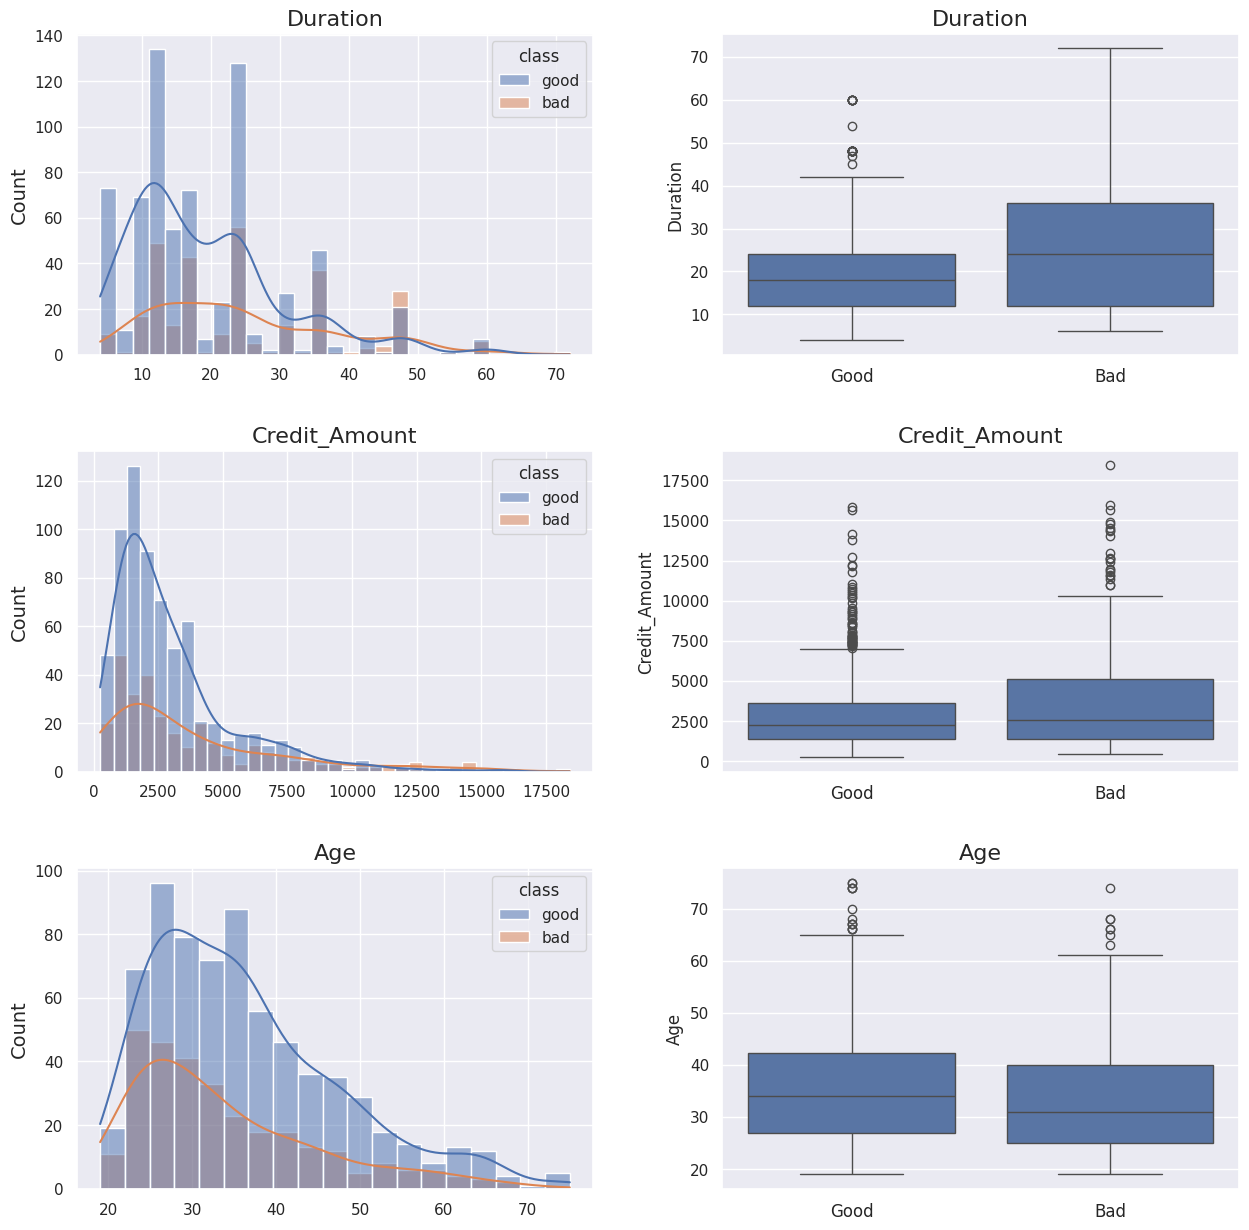

In [8]:
# Select numerical variables
numerical = ['duration', 'credit_amount', 'age']

# Specify plot size and loop over each variable
plt.figure(figsize=(15, 15))
i = 1
for col in numerical:
    # Plot the data using histograms, split by class
    plt.subplot(3, 2, i)
    sns.histplot(x=col, data=credit, hue='class', kde=True)
    plt.title(col.title(), size=16)
    plt.xlabel("")
    plt.ylabel("Count", size=14)

    # Plot the data using Boxplots
    plt.subplot(3, 2, i+1)
    ax = sns.boxplot(x='class', y=col, data=credit)
    ax.set_xticklabels(["Good", "Bad"], size=12)
    plt.title(col.title(), size=16)
    plt.ylabel(col.title(), size=12)
    plt.xlabel("")

    i += 2

plt.subplots_adjust(hspace=0.3, wspace=0.25)

- The median duration for bad credit risk is slightly higher than for good credit risk.
- Most credits are lower than 5,000. 75% are lower than 4,000 as we saw earlier.
- Most credits are taken by relatively young people - 40 or younger. Those with bad credit risk are in general slightly younger.
- Although none are extreme, there are some outliers. This can and should be confirmed with a statistical method such as the *z-score* or *Tukey's method*. The boxplots above are based on the same interquartile range (IQR) method as Tukey's method. Using the standard threshold of 1.5 * IQR we see that there are quite a lot of outliers in the `credit_amount` column. However, all in all, most values seem reasonable and we can leave them as they are for now.


By a visual inspection, none of the distributions seem normal. We should test for normality with a test such as Shapiro-Wilk though. For samples sizes > 5,000 the test statistic is accurate but the p-value might not be. Since our sample size is 1,000, both should be accurate.

In [9]:
print("Duration:")
print(stats.describe(credit["duration"]))
print(stats.shapiro(credit["duration"]))

print("\nCredit Amount:")
print(stats.describe(credit["credit_amount"]))
print(stats.shapiro(credit["credit_amount"]))

print("\nAge:")
print(stats.describe(credit["age"]))
print(stats.shapiro(credit["age"]))

Duration:
DescribeResult(nobs=np.int64(1000), minmax=(np.int64(4), np.int64(72)), mean=np.float64(20.903), variance=np.float64(145.41500600600605), skewness=np.float64(1.0925422109540106), kurtosis=np.float64(0.9091948811374047))
ShapiroResult(statistic=np.float64(0.8997879376569183), pvalue=np.float64(4.906432642671475e-25))

Credit Amount:
DescribeResult(nobs=np.int64(1000), minmax=(np.int64(250), np.int64(18424)), mean=np.float64(3271.258), variance=np.float64(7967843.470906908), skewness=np.float64(1.946702018941924), kurtosis=np.float64(4.265163377213492))
ShapiroResult(statistic=np.float64(0.7933961638083256), pvalue=np.float64(8.608545621331088e-34))

Age:
DescribeResult(nobs=np.int64(1000), minmax=(np.int64(19), np.int64(75)), mean=np.float64(35.546), variance=np.float64(129.4012852852853), skewness=np.float64(1.019207521364841), kurtosis=np.float64(0.5868108307295379))
ShapiroResult(statistic=np.float64(0.917471229910265), pvalue=np.float64(6.382098308916094e-23))


Although both skweness and kurtosis fall within the threshold of normality (roughly ±3) for all three variables (except perhaps kurtosis for `credit_amount`), based on the visualisations and the Shapiro-Wilk test, we can reject that the distributions are normal.

We can additionally plot the numerical variables against each other using a combination of scatter and kde plots. This allows us to better see how the variables are affected by each other. By also fitting regression lines, it becomes slightly easier to interpret.

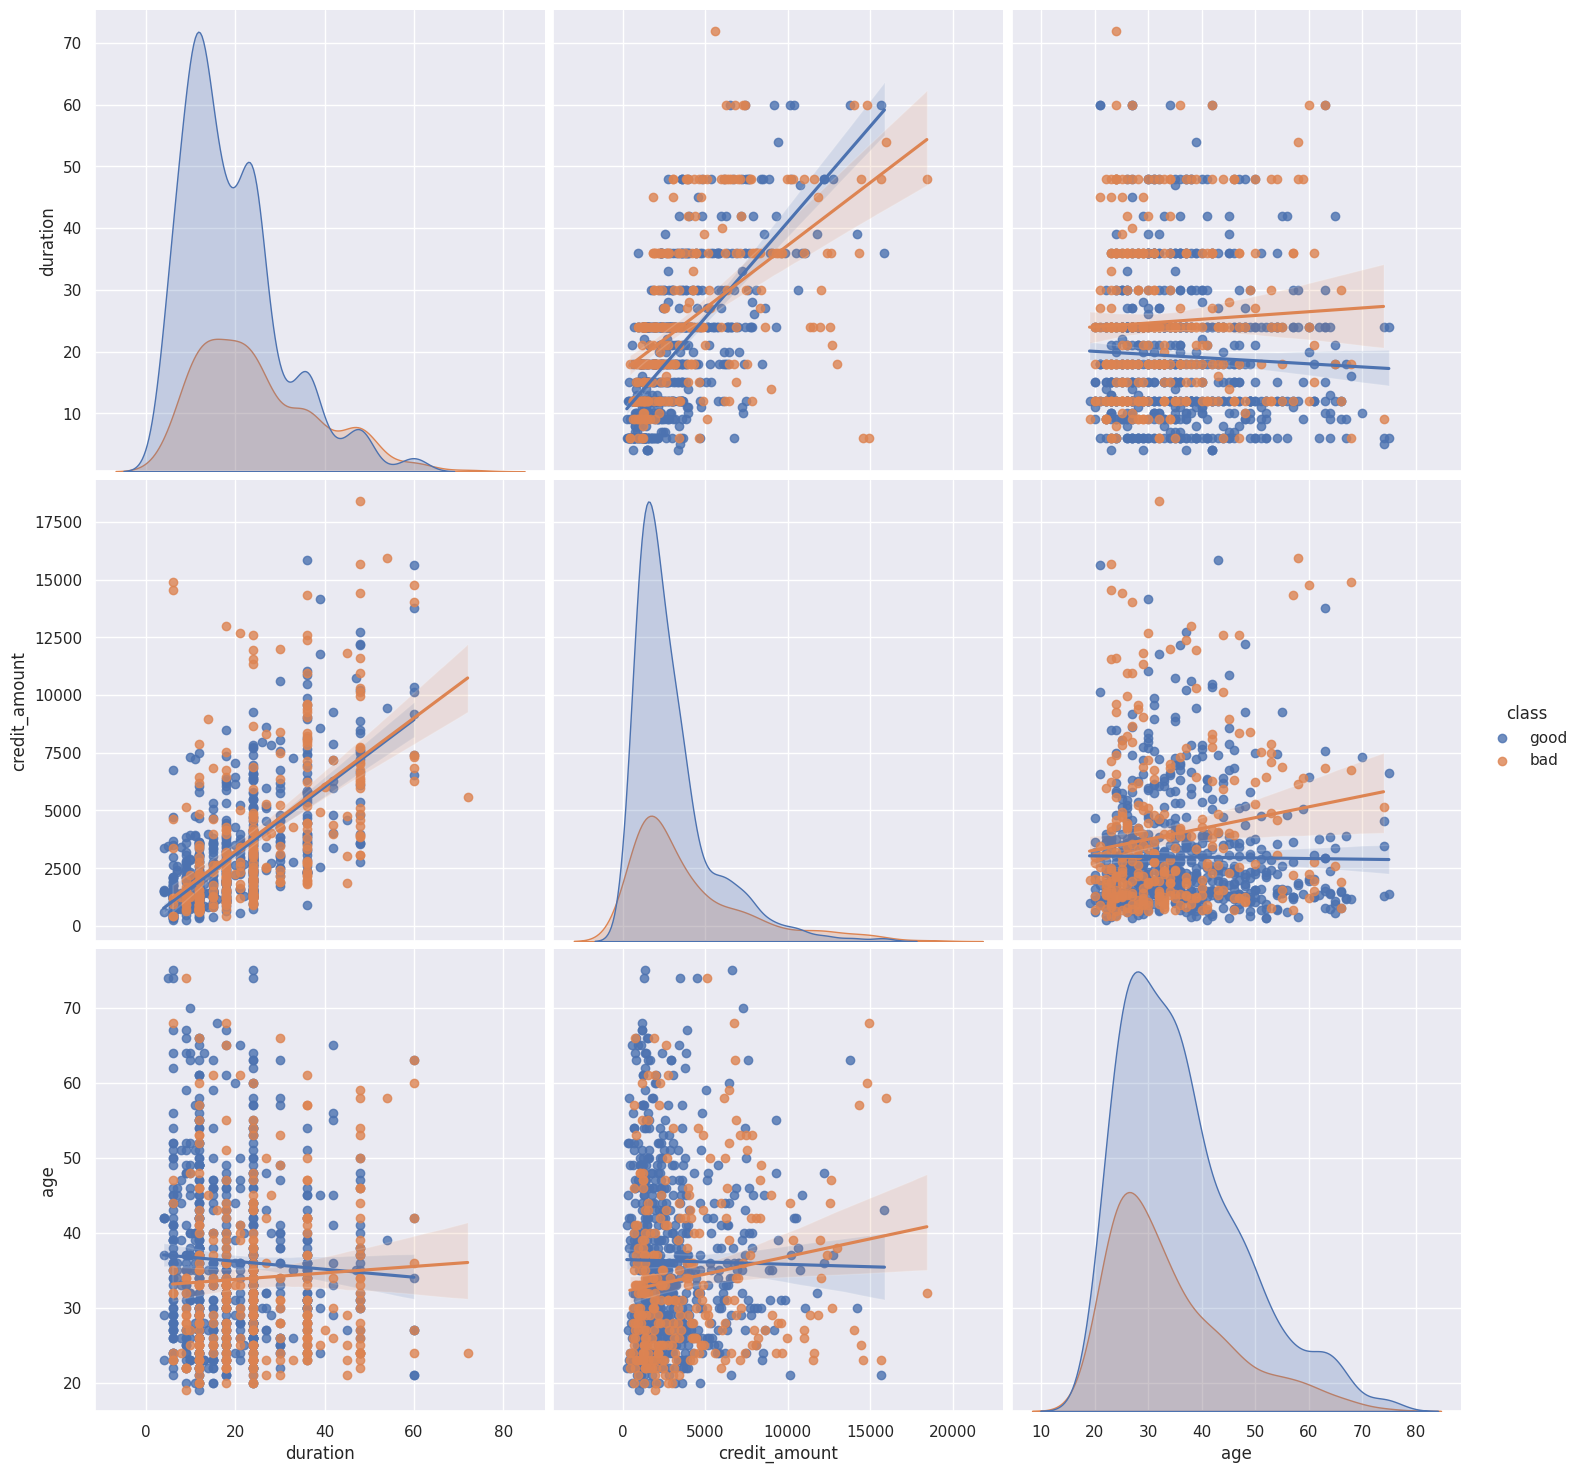

In [10]:
# Plot numerical variables against each other
sns.pairplot(credit[numerical+["class"]], hue="class",
             kind='reg', height=5);

We note that there seem to be a strong correlation between `duration` and `credit_amount`, while it's significantly weaker between `duration` and `age` and between `credit_amount` and `age`.

It's reasonable that with larger `credit_amount`s, it also takes more time to pay it back.

Apparently, neither `duration` nor `credit_amount` are much affected by the age of the person taking the credit. This is somehow reasonable as there can be other factors that play bigger roles, such as the person's economical situation at the time, number of dependents (kids), employment etc., etc.

### Categorical Variables

Plot the categorical variables to display their respective class counts.

The columns `installment_commitment`, `residence_since`, `existing_credits` and `num_dependents` are all discrete ordinal variables, meaning that there is a natural ordering of the values. As for the purpose of visualisation, we can plot them using the same approach as the categorical variables.

Other columns, such as `checking_status` and `employment` probably possess similar characteristics, but they already count as categorical.

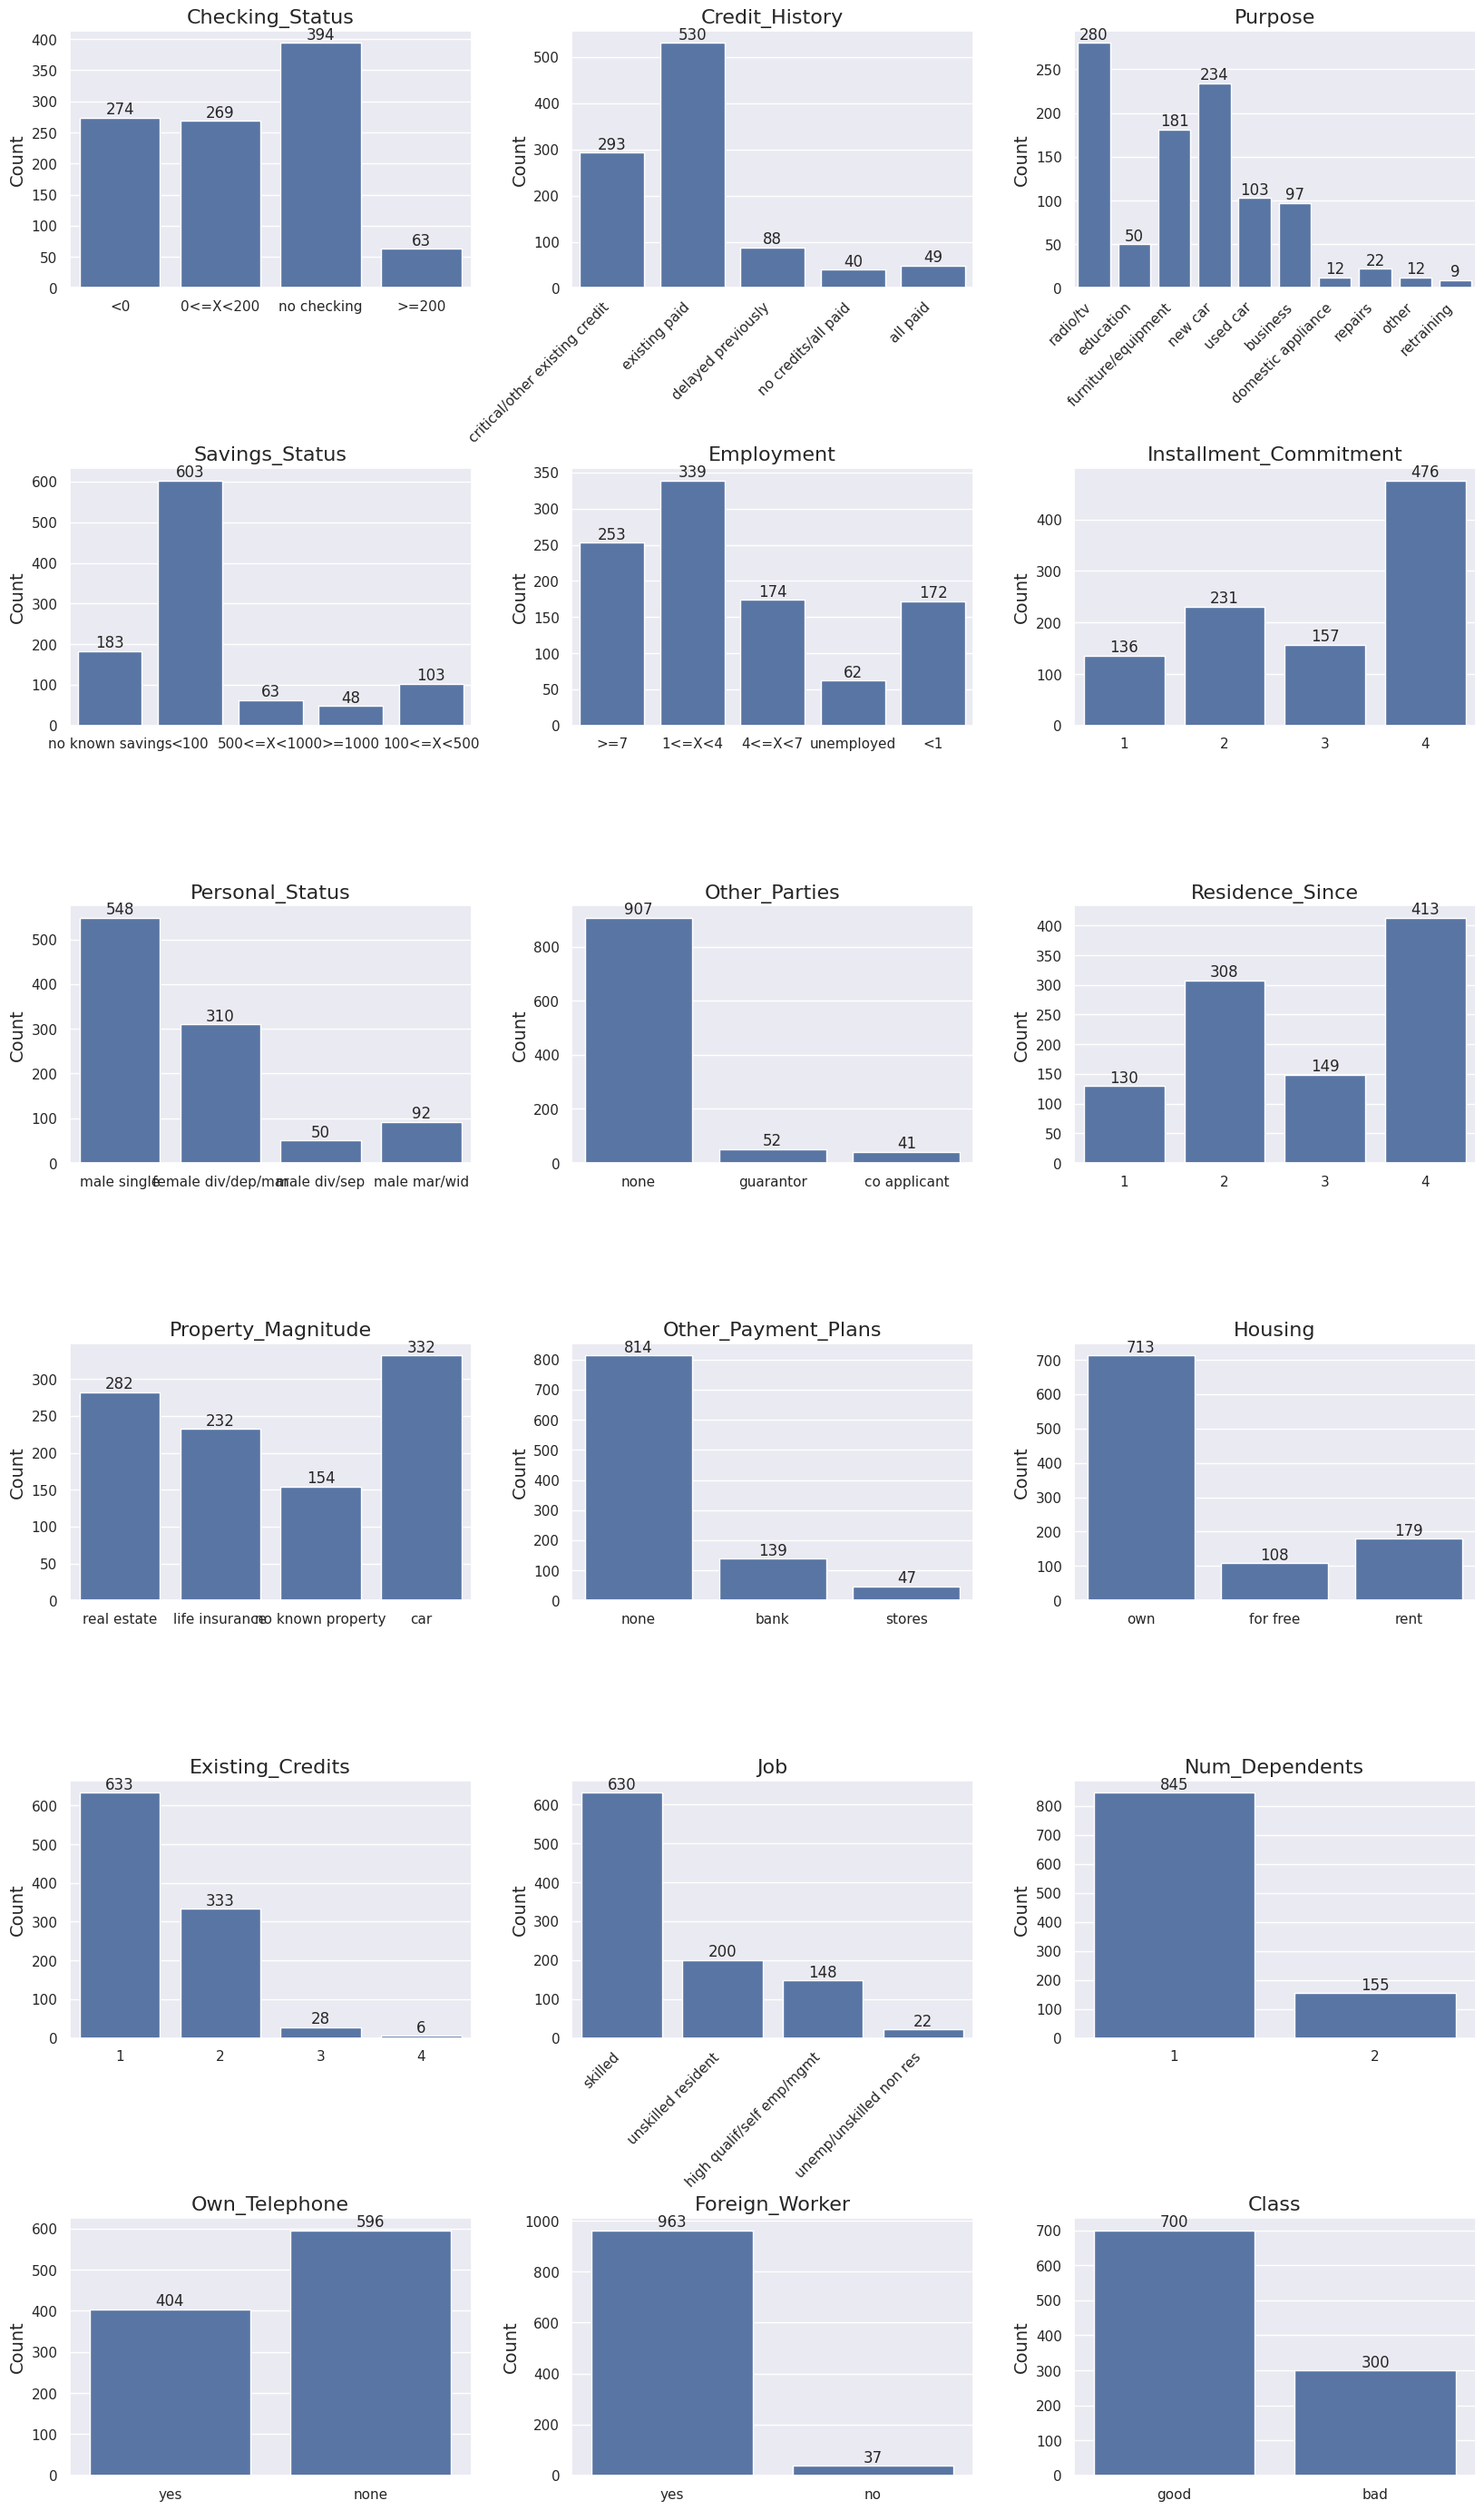

In [11]:
# Select categorical variables
categorical = [col for col in credit.columns if col not in numerical]

plt.figure(figsize=(20, 35))
for i, col in enumerate(credit[categorical], 1):

    # Plot corresponding variable
    plt.subplot(6, 3, i)
    ax = sns.countplot(x=col, data=credit)

    # Adjust labels and title. Display each class count
    plt.xlabel("")
    plt.ylabel("Count", size=14)
    plt.title(col.title(), size=16)
    ax.bar_label(ax.containers[0])

    # Rotate long class names in some columns to make them easier to read
    if col in ['credit_history', 'purpose', 'job']:
        plt.xticks(rotation=45, horizontalalignment='right')

plt.subplots_adjust(hspace=0.7, wspace=0.25)

Among other things, we learn the following by studying above plot. I've added some additional comments and thoughts as well.

- There are five or fewer classes in each categorical column. Only `purpose` has more with 10.
- Most seem to take credit to buy a radio/tv, a new car or furniture. Hardly solid investments I'd say.
- 60% have few savings (`savings_status` = `<100`).
- Relatively few are unemployed (6.2%).
- 55% are single males. Why do males make up three classes while females only one?
- 91% take the credit on their own.
- 71% own their apartment/house. This is great!
- 63% have one existing credit.
- 63% have skilled job types while additionally 15% have highly skilled job types.
- 85% of credit takers have one dependent they need to provide for.
- Only 40% own a telephone. The data is probably not from this nor the previous decade (or perhaps, they refer to cell phones rather than the old school phones?).  
- 96% are foreign workers. Is this really representative of the population or are we looking at a very biased sample?
- We have a slightly unbalanced dataset. 70% have good credit rating (`class = good`), while 30% have bad. (**This is the target variable**.)


Since the largest class make up 70% of the data, a perfectly naive model that always predicts this class would achieve 70% accuracy. This would obvisouly not be helpful, and our models should thus at least have an accuracy of 70% to be useful. **Baseline model accuracy is therefore: 70%.**


Note that the differences in counts in each variable should be checked using more formal statistical tests. The *chi-square test* is a common option - it can check all categorical columns at once.

<br>


## Split the Data into Development and Test sets

In order to have a dedicated dataset for testing, let's split it up and store it in different files.

In [12]:
import os

# Create directories if they don't exist
os.makedirs('../datasets/cleaned/train', exist_ok=True)
os.makedirs('../datasets/cleaned/test', exist_ok=True)

# Split the data into development and test sets
credit_dev, credit_test = train_test_split(credit, test_size=0.2, random_state=89, stratify=credit['class'])

# Save files for later
credit_dev.to_csv('../datasets/cleaned/train/credit_train.csv', index=False)
credit_test.to_csv('../datasets/cleaned/test/credit_test.csv', index=False)


## Identify Features with the strongest Correlation to Credit Risk

There are many approaches we can take here. One way is to train a model and calculate the importance each feature has for predicting the target variable. Depending on the choice of algorithm, the importance is normally referred to as *feature importance* or *model coefficients*.

We can also train many models, starting out with the entire feature set, and remove one-by-one the feature that contributes the least until we end up with the top three. With this approach you are most likely to find the "best" feature set. However, this takes comparably a lot of time and we won't do that here.

Instead, we will calculate Pearson correlation coefficent for all features relative the target variable and display the results in a correlation matrix. It's a very fast approach while also providing us with a nice overview of each feature's contribution and their inter-correlations. The disadvantage is that features are only selected based on their *individual* contribution rather than *combined* contribution with other features.

We will start by reordering the columns so the target variable is the first column. This will make it easier to interpret the correlation matrix.

In [13]:
# Reorder columns so the target variable is at the first position
cols = list(credit_dev.columns)
cols.remove('class')
cols.insert(0, 'class')
credit_dev = credit_dev[cols]

# Randomly shuffle the data to minimise the effect of randomness on our results
credit_enc = credit_dev.sample(frac=1.0, random_state=55)

Next, we have to convert all columns into numerical to be able to calculate correlations. To facilitate, we convert the target variable in the same way by using the `OrdinalEncoder`. It's not completely accurate to encode all columns as ordinal categorical - we should instead aim for one-hot encoding in some cases - but since that will expand the feature significantly, with increased training time as a result, we will take this shortcut. The performance will likely only vary slightly.

In [14]:
# Select all categorical columns
# categorical = credit_enc.select_dtypes(include=['object']).columns
categorical_columns = [c for c in credit_enc.columns if c not in numerical]

# Define encoder. As we are dealing with categorical variables, make sure that the output are integers
oe = OrdinalEncoder(dtype=np.int64)

# Transform the categorical columns
credit_enc[categorical] = oe.fit_transform(credit_enc[categorical])

# Verify that it looks as expected
credit_enc.head()

,class,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
832,0,1,45,4,0,11816,2,3,1,3,2,3,0,29,1,2,1,1,0,0,1
21,1,1,6,3,6,2647,1,0,1,3,2,2,3,44,1,2,0,1,1,0,1
563,0,0,36,3,4,12389,4,0,0,3,2,3,2,37,1,0,0,1,0,1,1
394,1,3,9,1,3,2406,2,4,1,3,2,2,0,31,1,1,0,0,0,0,1
261,1,1,24,3,6,1603,2,3,3,0,2,3,0,55,1,1,0,1,0,0,1


Calculate and display Pearson correlation matrix.

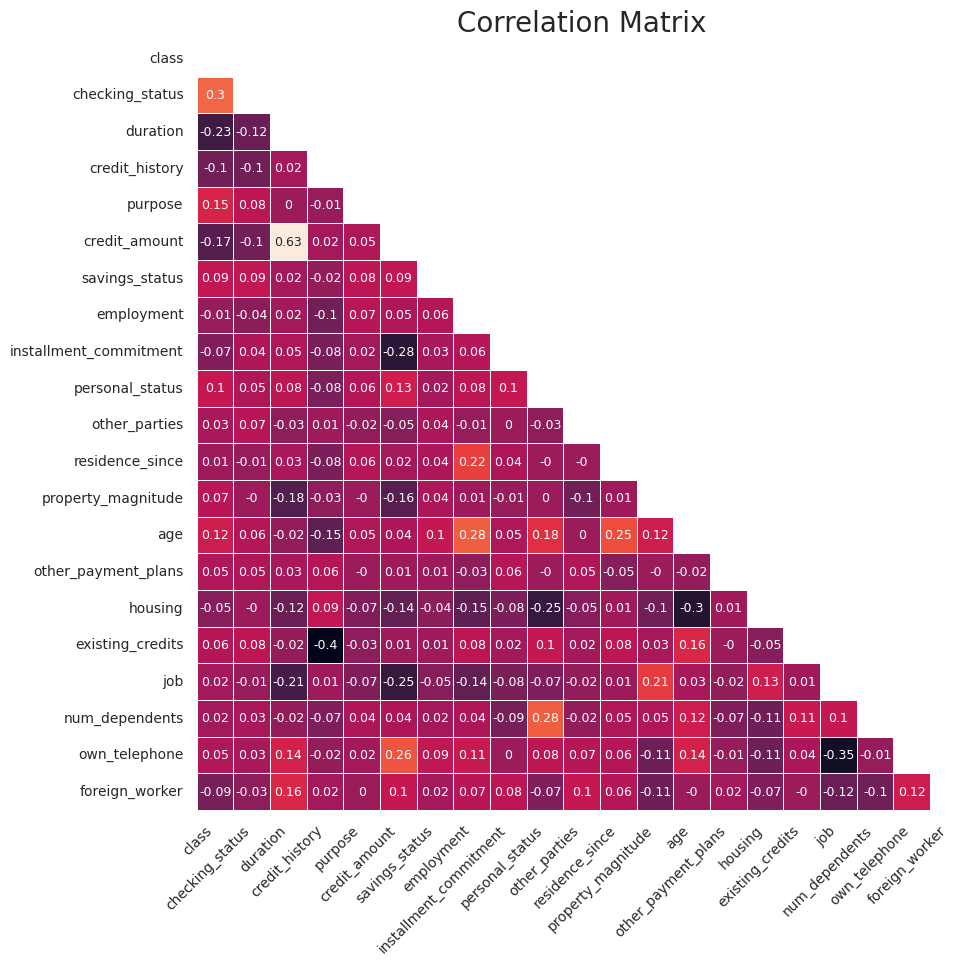

In [15]:
# Calculate correlation matrix
corr = credit_enc.corr()

# Create mask to remove the mirrored diagonal of the matrix
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot correlation matrix
plt.figure(figsize=(10, 10))
with sns.axes_style("white"):
    sns.heatmap(np.round(corr, 2), square=True,  annot=True,
                cbar=False,  linewidth=.5, mask=mask, annot_kws={"size": 9})

plt.title("Correlation Matrix", size=20)
plt.xticks(size=10, rotation=45, horizontalalignment='right')
plt.yticks(size=10);

We find that `checking_status`, `duration` and `credit_amount` are highest correlated with the target variable. Note that we consider the absolute value since we don't really care wheather the target variable is positively or negatively affected by a particular feature.

Additionally, we observe that there is little collinearity and that there are many variables that barely have any correlation with the target variable (e.g. `num_dependents`, `residence_since` and `employment`). The previously identified strong correlation between `credit_amount` and `duration` is confirmed.

Now when we have a slightly better general understanding, we can automate the selection of the top features using Scikit-learn's `SelectKBest` and the chi-squared stats `chi2` methods. There's a lot of experimentation we can do to find the optimal set of features, but to keep it simple, I will quite arbitrarly select the top 10. Note that we're also not considering any feature engineering.

Before that, we split the data into feature set (`X`) and target (`Y`).

In [16]:
# Select features and target variable
X = credit_enc[credit_enc.columns.difference(['class'])]
Y = credit_enc['class']

In [17]:
# Select the top 10 most important features using chi-squared
selector = SelectKBest(chi2, k=10).fit(X, Y)
X = pd.DataFrame(selector.transform(X),
                 columns=selector.get_feature_names_out())

# Display the resulting feature set
X.head()

,age,checking_status,credit_amount,credit_history,duration,existing_credits,personal_status,property_magnitude,purpose,savings_status
0,29,1,11816,4,45,1,3,0,0,2
1,44,1,2647,3,6,0,3,3,6,1
2,37,0,12389,3,36,0,3,2,4,4
3,31,3,2406,1,9,0,3,0,3,2
4,55,1,1603,3,24,0,0,0,6,2


Next, we'll split into train and test sets, keeping 80% for training and 20% for testing.

In [18]:
# Split into train and test sets.
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=89, stratify=Y)
trainX.head()

,age,checking_status,credit_amount,credit_history,duration,existing_credits,personal_status,property_magnitude,purpose,savings_status
30,23,0,836,3,12,0,0,1,4,0
263,41,0,3979,3,48,1,3,0,6,4
533,49,0,8386,1,30,0,3,1,3,2
161,42,0,5084,3,24,0,0,0,6,4
618,42,3,1544,1,4,2,3,3,6,2


## Model the Credit Risk & Evaluate model performance

We are working with a fairly small dataset at 1,000 rows. This means that there is a significant risk that when we split it into train and test sets *only once*, we might be "lucky" and end up with all the "easy" samples in the test set by pure chance. This would lead to better than expected results on the test set and a seemingly better model than we think we have. Conversely, the opposite can happen as well.

A safer approach is to split the data many times in different ways and average the results. This way we are less likely to over-estimate the model performance by pure chance. This is referred to as cross-validation. We will use 10-fold cross-validation as it is frequently used and normally works well. Since the dataset is small, it shouldn't take too long to run either.

It's common to experiment a lot during model development. But in order to speed things up, we will do a light version of it. Thus, we will evaluate three different models; Logistic Regression, Random Forest and LightGBM. Additionally, we will also do basic parameter tuning to optimize the models, while making sure to use nested cross-validation to not bias the results.

For Logistic Regression, we need to scale the data for the model to properly learn. If a feature is significantly larger than the others (such as `credit_amount` vs `checking_status`), the model might over-estimate the importance of that feature, often leading to worse results. We can use `StandardScaler` to center the data round 0. Tree-based models such as Random Forest and LightGBM don't need this.

A `Pipeline` will make sure that these steps are conducted properly by preventing data leakage.

We will use `AUC` as the main evaluation metric to tune and compare the trained models. It's a comparably complete metric that takes into account both True Positive and False Positive rates. Additionally, we will measure specificity, recall and accuracy to get a more holistic picture of the model performance.



### Logistic Regression

Start by training and evaluating a Logistic regression model. We will tune the regularisation strength `C`. *Lower* values mean *more* regularization, which normally helps the model to better generalise to unseen data. We can use Scikit-Optimize's `BayesSearchCV` for this, which smoothly integrates with scikit-learn models.

In [19]:
%%time

# Specify model and subsequent hyperparameters to tune
lr = LogisticRegression(max_iter=1000)
parameters = {
        'clf__C': Real(1e-3, 1e+2, prior='log-uniform'),
}

# Create final pipeline
pipeline = Pipeline(steps=([('scaler', StandardScaler()),
                            ('clf', lr)]))

# Specify scoring metrics
scoring = {
        "auc"        : "roc_auc",
        "specificity": make_scorer(specificity_score, average="weighted"),
        "recall"     : "recall",
        "accuracy"   : "accuracy",
}

# Perform hyperparameter tuning with BayesSearchCV over 10 folds with AUC as refit metric.
gs_lr = BayesSearchCV(pipeline, parameters, cv=10, scoring="roc_auc",
                      refit="auc", random_state=500, n_iter=10)

# We need to fit the BayesSearchCV object to the train data in order to make predictions with the best model later
gs_lr.fit(trainX, trainY)

# Run nested cross-validation over 10 folds
lr_scores = cross_validate(gs_lr, X, Y, cv=10, n_jobs=-1, verbose=1,
                        return_train_score=True, scoring=scoring)

# Make cross-validated predictions
lr_preds = cross_val_predict(gs_lr.best_estimator_, X, Y, cv=10, n_jobs=-1)

time.sleep(1)
for score in lr_scores:
        print(f"{score:<17}: {np.mean(lr_scores[score]):.2f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.5s finished


fit_time         : 2.47
score_time       : 0.02
test_auc         : 0.74
train_auc        : 0.75
test_specificity : 0.42
train_specificity: 0.43
test_recall      : 0.95
train_recall     : 0.95
test_accuracy    : 0.72
train_accuracy   : 0.73
CPU times: user 5.82 s, sys: 39.1 ms, total: 5.86 s
Wall time: 24.5 s


In [20]:
# Save best LR model pipeline
#best_lr_model = gs_lr.best_estimator_
#print(f"Best model:\n{gs_lr.best_estimator_}")
#joblib.dump(best_lr_model, 'models/lr_model_pipeline.pkl')

Best model:
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=0.030956075088984472, max_iter=1000))])


FileNotFoundError: [Errno 2] No such file or directory: 'models/lr_model_pipeline.pkl'

In [ ]:
#%%bash

#model="lr_model_pipeline.pkl"
#sizeKB=$(du -k "models/$model" | cut -f 1)
#echo Size for $model is $sizeKB kb

We can take a closer look at the model performance by creating a confusion matrix, plotting the ROC AUC curve and display some metrics with sklearn's `classification_report` as follows. Display one normalised and one confusion matrix with real values.

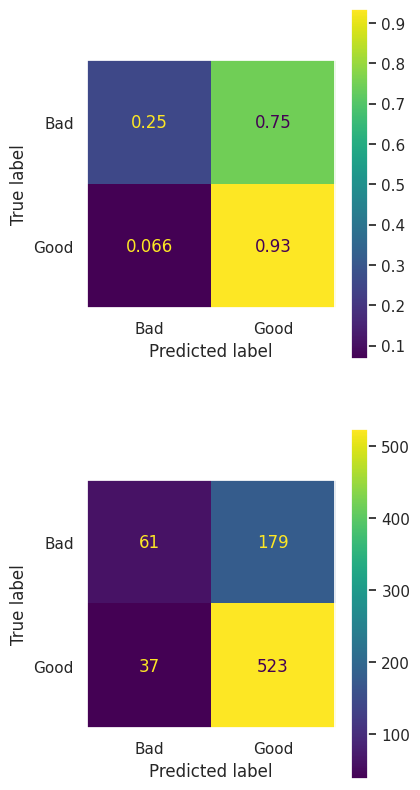

In [21]:
# Confusion matrix for the Logistic regression model
f, axs = plt.subplots(2, 1, figsize=(4, 10))
ConfusionMatrixDisplay.from_predictions(Y, lr_preds,
                                        display_labels=['Bad', 'Good'],
                                        normalize="true",
                                        ax=axs[0])
axs[0].grid()
ConfusionMatrixDisplay.from_predictions(Y, lr_preds,
                                        display_labels=['Bad', 'Good'],
                                        normalize=None,
                                        ax=axs[1])
axs[1].grid();

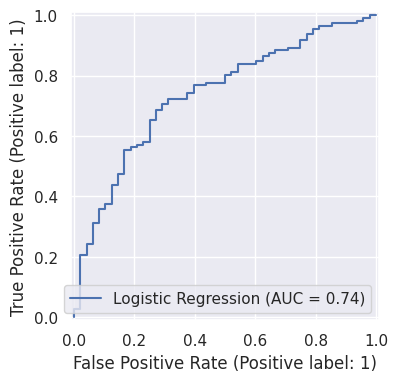

In [22]:
# Plot ROC AUC curve on the test set
f, axs = plt.subplots(1, 1, figsize=(5, 4))
RocCurveDisplay.from_estimator(gs_lr.best_estimator_, testX, testY,
                               name="Logistic Regression",
                               ax=axs);

In [23]:
# Classification report for Logistic Regression
print(classification_report(Y, lr_preds, target_names=['Bad', 'Good']))

              precision    recall  f1-score   support

         Bad       0.62      0.25      0.36       240
        Good       0.75      0.93      0.83       560

    accuracy                           0.73       800
   macro avg       0.68      0.59      0.59       800
weighted avg       0.71      0.73      0.69       800



AUC on the *test* set is 70% while 74% when cross validated. We note that the model predicts the sample as `good` (1) in most cases, including when it shouldn't (which results in many false positives). We also note that both precision, recall (equivalent to the diagonal) and the f1-score are pretty low for the `bad` (0) class.

### Random Forest

Train and evaluate a Random Forest model.

We can exclude the pipeline since we don't need to scale the data. The `n_estimators` parameter specify how many individual trees the model compose of. More trees normally mean that it can better learn the data. We will tune this hyperparameter together with `max_depth`, which specifies how deep each tree can grow (deeper trees can split the data more fine-grained, but there is a larger risk of overfitting).

In [25]:
%%time

# Specify model and subsequent hyperparameters to tune
rf = RandomForestClassifier(random_state=99)
parameters = {'n_estimators': Integer(10, 200, prior='uniform'),
              'max_depth': Integer(2, 8, prior='uniform'),
              'min_samples_split': Integer(2, 5, prior='uniform'),
}

# Perform hyperparameter tuning with BayesSearchCV over 10 folds with AUC as refit metric.
gs_rf = BayesSearchCV(rf, parameters, cv=10, scoring="roc_auc",
                      refit="auc", random_state=500, n_iter=10)

# Fit the BayesSearchCV object to the train data
gs_rf.fit(trainX, trainY)

# Run nested cross-validation over 10 folds
rf_scores = cross_validate(gs_rf, X, Y, cv=10, n_jobs=-1, verbose=1,
                           return_train_score=True, scoring=scoring)

# Make cross-validated predictions
rf_preds = cross_val_predict(gs_rf, X, Y, cv=10, n_jobs=-1, verbose=3)

time.sleep(1)
for score in rf_scores:
        print(f"{score:<17}: {np.mean(rf_scores[score]):.2f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.8min finished


fit_time         : 37.90
score_time       : 0.07
test_auc         : 0.78
train_auc        : 0.95
test_specificity : 0.54
train_specificity: 0.74
test_recall      : 0.92
train_recall     : 0.98
test_accuracy    : 0.76
train_accuracy   : 0.88
CPU times: user 24.4 s, sys: 414 ms, total: 24.8 s
Wall time: 6min 28s


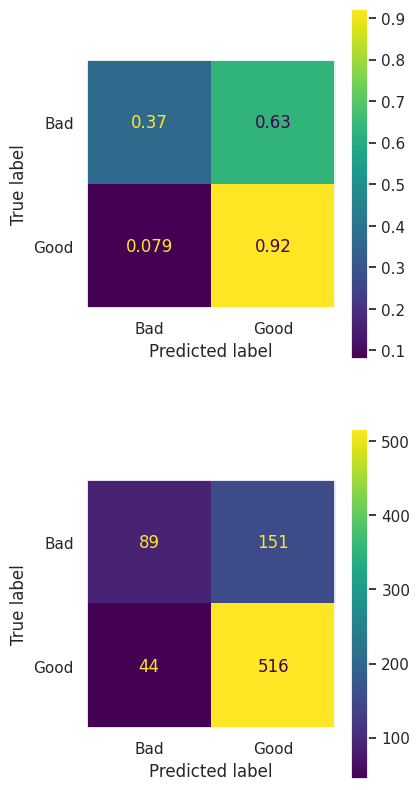

In [26]:
# Confusion matrix for Random Forest
f, axs = plt.subplots(2, 1, figsize=(4, 10))
ConfusionMatrixDisplay.from_predictions(Y, rf_preds,
                                        display_labels=['Bad', 'Good'],
                                        normalize="true",
                                        ax=axs[0])
axs[0].grid()
ConfusionMatrixDisplay.from_predictions(Y, rf_preds,
                                        display_labels=['Bad', 'Good'],
                                        normalize=None,
                                        ax=axs[1])
axs[1].grid();

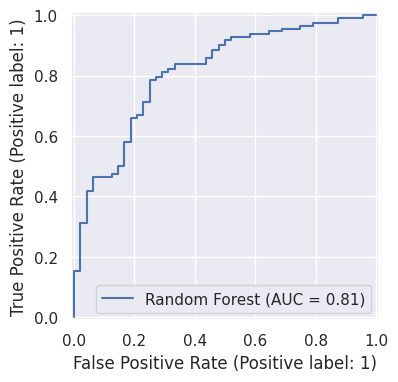

In [27]:
# Plot ROC AUC curve on the test set
f, axs = plt.subplots(1, 1, figsize=(5, 4))
RocCurveDisplay.from_estimator(gs_rf.best_estimator_, testX, testY,
                               name="Random Forest",
                               ax=axs);

In [28]:
# Classification report for Random Forest
print(classification_report(Y, rf_preds, target_names=['Bad', 'Good']))

              precision    recall  f1-score   support

         Bad       0.67      0.37      0.48       240
        Good       0.77      0.92      0.84       560

    accuracy                           0.76       800
   macro avg       0.72      0.65      0.66       800
weighted avg       0.74      0.76      0.73       800



AUC on the test set is 81% while its cross-validated AUC is 78%. Random Forest also seem to predict the sample as `good` (1) in most cases, including when it shouldn't (which results in many false positives). Although perhaps more equally distributed than for Logistic regression, precision, recall (equivalent to the diagonal) and the f1-score are very low for the `bad` (0) class here as well.


Additionally, we note that Random Forest takes close to 10 times longer to train than Logistic Regression.

### LightGBM

In [29]:
%%time

# Specify model and subsequent hyperparameters to tune. There are many more parameters to choose from
lgbm = LGBMClassifier(random_state=99)
parameters = {'n_estimators': Integer(10, 200, prior='uniform'),
              'max_depth': Integer(2, 8, prior='uniform'),
              'num_leaves': Integer(20, 60, prior='uniform'),
}

# Perform hyperparameter tuning with BayesSearchCV over 10 folds with AUC as refit metric.
# LightGBM is faster than RF so we can try more combinations (20 instead of 10)
gs_lgbm = BayesSearchCV(lgbm, parameters, cv=10, scoring="roc_auc",
                       refit="auc", random_state=500, n_iter=20)

# Fit the BayesSearchCV object to the train data
gs_lgbm.fit(trainX, trainY)

# Run nested cross-validation over 10 folds
lgbm_scores = cross_validate(gs_lgbm, X, Y, cv=10, n_jobs=-1, verbose=1,
                           return_train_score=True, scoring=scoring)

# Make cross-validated predictions
lgbm_preds = cross_val_predict(gs_lgbm, X, Y, cv=10, n_jobs=-1, verbose=3)

time.sleep(1)
for score in lgbm_scores:
        print(f"{score:<17}: {np.mean(lgbm_scores[score]):.2f}")

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.8min finished


fit_time         : 36.24
score_time       : 0.03
test_auc         : 0.77
train_auc        : 0.93
test_specificity : 0.55
train_specificity: 0.76
test_recall      : 0.89
train_recall     : 0.95
test_accuracy    : 0.74
train_accuracy   : 0.87
CPU times: user 34.4 s, sys: 554 ms, total: 35 s
Wall time: 6min 14s


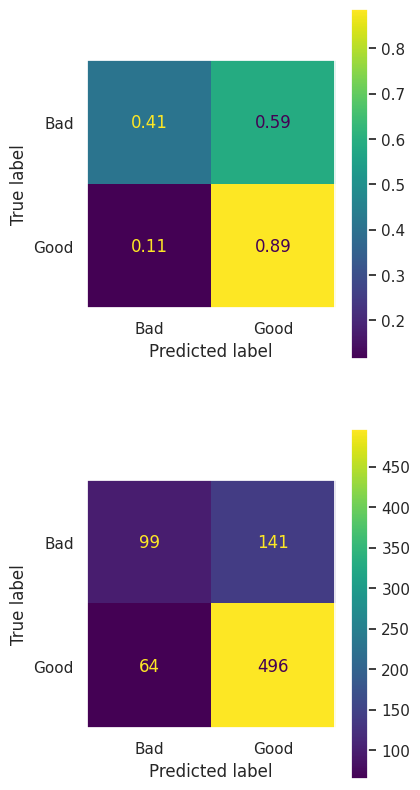

In [30]:
# Confusion matrix for LightGBM
f, axs = plt.subplots(2, 1, figsize=(4, 10))
ConfusionMatrixDisplay.from_predictions(Y, lgbm_preds,
                                        display_labels=['Bad', 'Good'],
                                        normalize="true",
                                        ax=axs[0])
axs[0].grid()
ConfusionMatrixDisplay.from_predictions(Y, lgbm_preds,
                                        display_labels=['Bad', 'Good'],
                                        normalize=None,
                                        ax=axs[1])
axs[1].grid();

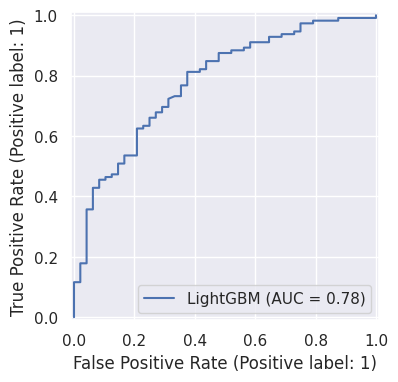

In [31]:
# Plot ROC AUC curve on the test set
f, axs = plt.subplots(1, 1, figsize=(5, 4))
RocCurveDisplay.from_estimator(gs_lgbm.best_estimator_, testX, testY,
                               name="LightGBM",
                               ax=axs);

In [32]:
# Classification report for LightGBM
print(classification_report(Y, lgbm_preds, target_names=['Bad', 'Good']))

              precision    recall  f1-score   support

         Bad       0.61      0.41      0.49       240
        Good       0.78      0.89      0.83       560

    accuracy                           0.74       800
   macro avg       0.69      0.65      0.66       800
weighted avg       0.73      0.74      0.73       800



LightGBM achieves an AUC of 80% on the test set while its cross-validated AUC is 77%.

# PROBABILITY OF DEFAULT

Part 2: PD Model with Machine Learning, Performance, Scorecard, Credit Score, and Cutoffs

## Probability of Default (PD)

**Probability of Default** refers to the likelihood that a borrower will fail to repay their debt (credit card, mortgage, or other loans) within a one-year period. Simply put, it estimates the chance that a customer will default on their loan.

- Expressed as a percentage between **0% and 100%**.
- A **higher probability** means a **greater risk of default**.

---

## Logistic Regression for PD Modeling

We use **logistic regression** (implemented via the `scikit-learn` library) to model the probability of default based on borrower data.

---

## Scorecard

A **scorecard** is a tool that translates the PD model's output into an easy-to-understand credit score. It is designed to be interpretable by non-experts, as required by financial regulators such as the Basel Accord and various central banks.

Key points about scorecards:
- Use **discretized variables**, even for continuous features, to simplify explanations.
- Reflect the **high cost of misclassification** (wrong approvals or rejections).
- Provide **standardized minimum and maximum scores**. For example, the widely known FICO score ranges from **300 to 850**.
- Make the PD model coefficients more interpretable by converting them into score points.

Our approach converts the logistic regression PD model into a scorecard for easier decision-making.

---

## Loan Approval Cutoffs

A critical question: **What cutoff credit score should be used to accept or reject loan applications?**

- Borrowers with scores **above the cutoff** are approved for loans.
- Borrowers with scores **below the cutoff** are rejected.

This cutoff balances the expected **loan approval rate** against the **loan rejection rate**, optimizing risk and business goals.

---

*This section provides the foundation for converting model outputs into actionable lending decisions based on credit scores and probabilities of default.*


In [36]:
features_all=credit_dev.columns

In [37]:
features_all

Index(['class', 'checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker'],
      dtype='object')

In [42]:
Y.head()

,class
832,0
21,1
563,0
394,1
261,1


In [40]:
for col in credit_dev.columns:
    print(f"Unique values for {col}:")
    print(credit_dev[col].unique())
    print("-" * 20)

Unique values for class:
['bad' 'good']
--------------------
Unique values for checking_status:
['<0' '0<=X<200' 'no checking' '>=200']
--------------------
Unique values for duration:
[24  6 30 21 36 15 10 12  9 42 18 33 48 26 60  4 45 11 27 20 54 16  5  8
  7 14 47 39 22 13 72 28 40]
--------------------
Unique values for credit_history:
['delayed previously' 'critical/other existing credit' 'existing paid'
 'all paid' 'no credits/all paid']
--------------------
Unique values for purpose:
['radio/tv' 'new car' 'used car' 'furniture/equipment' 'retraining'
 'repairs' 'business' 'education' 'domestic appliance' 'other']
--------------------
Unique values for credit_amount:
[ 1024  1199   590  5234  2993  3959  2788  1038  1274  2507  6948  2337
  3181  3577   932  1249  1155  9283  3114  3378  2039  2835  9271  2384
  2767  2764  1445  2121  3060  7966  8133  8648  1768  1282  1433  1076
  1216   936  1391  1412 14318  1568   874 14782  2100  1371  3878  2284
  4020  1552  5371   601  

In [47]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import statsmodels.api as sm

class LogisticRegression_with_p_values:

    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = LogisticRegression(*args,**kwargs)#,**kwargs)

    def fit(self,X,y):
        self.model.fit(X,y)
        # Reset index to ensure alignment
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)
        # add constant to the training data
        X = sm.add_constant(X)
        # Refit using statsmodels
        self.sm_model = sm.Logit(y,X)
        self.sm_result = self.sm_model.fit()

    def predict(self,X):
        return self.model.predict(X)

    def predict_proba(self,X):
        return self.model.predict_proba(X)

    def coef_(self):
        return self.model.coef_

    def intercept_(self):
        return self.model.intercept_

    def summary(self):
        return self.sm_result.summary()

    @property
    def p_values(self):
        return self.sm_result.pvalues[1:] # exclude the constant's p-value

In [48]:

# Creating an instance from 'LogisticRegression_with_p_values()' class.
reg = LogisticRegression_with_p_values()

In [68]:
# Fitting and obtaining coefs
reg.fit(trainX, trainY)

Optimization terminated successfully.
         Current function value: 0.520207
         Iterations 6


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [69]:
# creating a summary table
feature_name = trainX.columns.values
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg.coef_())
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg.intercept_()]
summary_table = summary_table.sort_index()
# We take the result of the newly added method 'p_values'
p_values = reg.p_values
# Adding the intercept for completeness. We add the value 'NaN' in the beginning of the variable with p-values.
p_values = np.append(np.nan, np.array(p_values))
# Adding a new column, called 'p_values', containing the values from the 'p_values' variable.
summary_table['p_values'] = p_values

summary_table

,Feature name,Coefficients,p_values
0,Intercept,[-0.020225534817334093],NaN
1,age,0.015054,3.468436e-02
2,checking_status,0.490087,9.554098e-11
3,credit_amount,-0.000042,4.582213e-01
4,credit_history,-0.168141,1.675667e-01
5,duration,-0.035915,1.760867e-03
6,existing_credits,-0.005788,6.988363e-01
7,personal_status,0.113307,7.020911e-02
8,property_magnitude,0.064141,2.194362e-01
9,purpose,0.107205,1.260192e-03


##Meaning in plain words

##(strong predictors) 🏆 →
checking_status, duration, purpose, age
##(not useful) 💤 →
credit_amount, credit_history, existing_credits,  personal_statusproperty_magnitude, savings_status (and Intercept is just the starting point)

In [74]:
trainX_new=trainX[['checking_status', 'duration', 'purpose', 'age']]

In [75]:
trainX_new.head()

,checking_status,duration,purpose,age
30,0,12,4,23
263,0,48,6,41
533,0,30,3,49
161,0,24,6,42
618,3,4,6,42


In [78]:
# Here we run a new model.
reg2 = LogisticRegression_with_p_values()
reg2.fit(trainX_new,trainY)

Optimization terminated successfully.
         Current function value: 0.527748
         Iterations 6


In [79]:
# Same as above.
feature_name = trainX_new.columns.values
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg2.coef_())
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg2.intercept_()]
summary_table = summary_table.sort_index()
summary_table

# We add the 'p_values' here, just as we did before.
p_values = reg2.p_values
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table
# Here we get the results for our final PD model.

,Feature name,Coefficients,p_values
0,Intercept,[-0.5287636664513825],NaN
1,checking_status,0.540712,1.382222e-11
2,duration,-0.037574,5.141664e-06
3,purpose,0.125857,1.298847e-03
4,age,0.024712,5.373039e-03


from matplotlib import pyplot as plt
summary_table['p_values'].plot(kind='hist', bins=20, title='p_values')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
summary_table.groupby('Feature name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
summary_table['p_values'].plot(kind='line', figsize=(8, 4), title='p_values')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(summary_table['Feature name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(summary_table, x='p_values', y='Feature name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [81]:
testX_new=testX[['checking_status', 'duration', 'purpose', 'age']]

In [82]:
# Calculating the predicted values for test data set
# based on the values of the independent variables
y_hat_test = reg2.model.predict(testX_new)
# calculating class probabilities for all classes
y_hat_test_proba = reg2.model.predict_proba(testX_new)

# an array of predicted discrete classess  (0s and 1s).
y_hat_test

array([1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1])

In [83]:
# first value of every sub-array is the probability for the observation to belong
# to the first class, i.e. 0,
#the second value is the probability for the observation to belong to the first class, i.e. 1.
y_hat_test_proba

array([[0.31552249, 0.68447751],
       [0.37915329, 0.62084671],
       [0.3417982 , 0.6582018 ],
       [0.17043713, 0.82956287],
       [0.35283424, 0.64716576],
       [0.77483143, 0.22516857],
       [0.06653691, 0.93346309],
       [0.50396699, 0.49603301],
       [0.14043627, 0.85956373],
       [0.75481274, 0.24518726],
       [0.10469924, 0.89530076],
       [0.1729952 , 0.8270048 ],
       [0.12883035, 0.87116965],
       [0.13395601, 0.86604399],
       [0.30925924, 0.69074076],
       [0.25475711, 0.74524289],
       [0.46473021, 0.53526979],
       [0.53978357, 0.46021643],
       [0.24847335, 0.75152665],
       [0.14062435, 0.85937565],
       [0.49758415, 0.50241585],
       [0.44049518, 0.55950482],
       [0.49290531, 0.50709469],
       [0.39349383, 0.60650617],
       [0.49926743, 0.50073257],
       [0.10815795, 0.89184205],
       [0.4531432 , 0.5468568 ],
       [0.27026354, 0.72973646],
       [0.54169694, 0.45830306],
       [0.18274187, 0.81725813],
       [0.

In [ ]:
# We store these probabilities of 1 (good) in a variable.
y_hat_test_proba = y_hat_test_proba[: ][: , 1]

# Array of probabilities of being 1.
y_hat_test_proba

In [86]:
targets_test_temp = testY

# Reseting the index of a dataframe.
targets_test_temp.reset_index(drop = True, inplace = True)

In [87]:
# Concatenating two dataframes consists of actual and predicted results
df_actual_predicted_probs = pd.concat([testY, pd.DataFrame(y_hat_test_proba)], axis = 1)

df_actual_predicted_probs.columns = ['targets_test', 'y_hat_test_proba']
df_actual_predicted_probs.shape

(160, 2)

In [88]:
# Making the index of one dataframe equal to the index of another dataframe.
df_actual_predicted_probs.index = testX_new.index

df_actual_predicted_probs.head()

,targets_test,y_hat_test_proba
242,0,0.684478
309,1,0.620847
105,1,0.658202
400,1,0.829563
124,0,0.647166


## ROC_ CURVE, GINNI SCORE, KS CURVE

AUC: 0.73
Gini: 0.47
KS statistic: 0.45


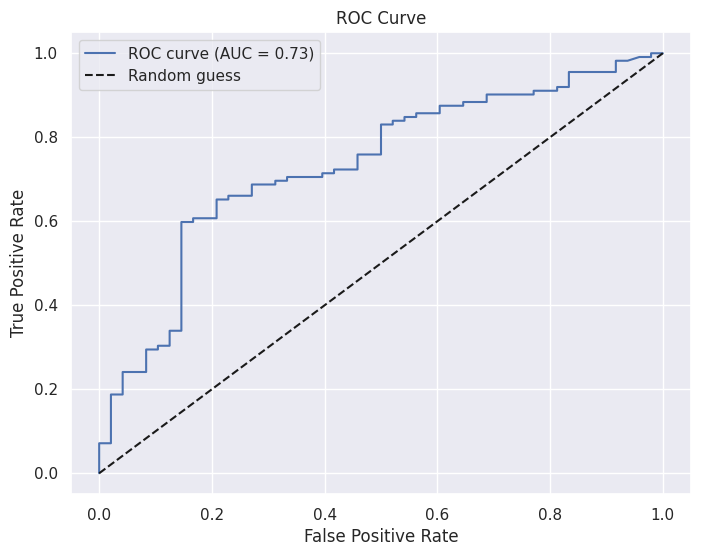

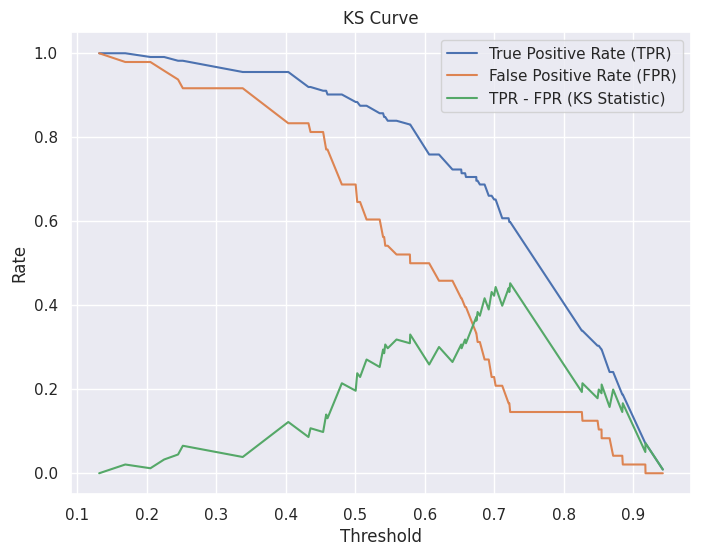

In [89]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['targets_test'], df_actual_predicted_probs['y_hat_test_proba'])

# Calculate AUC
auc_score = roc_auc_score(df_actual_predicted_probs['targets_test'], df_actual_predicted_probs['y_hat_test_proba'])
print(f"AUC: {auc_score:.2f}")

# Calculate Gini coefficient
gini_score = 2 * auc_score - 1
print(f"Gini: {gini_score:.2f}")

# Calculate KS statistic
ks_statistic = max(tpr - fpr)
print(f"KS statistic: {ks_statistic:.2f}")


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plot Gini curve (Lorenz curve)
# This is not a standard plot name, usually it refers to the Lorenz curve for inequality
# Assuming the user meant plotting TPR vs cumulative percentage of the positive class.
# However, the standard interpretation of Gini in classification is derived from AUC.
# I will skip plotting a "Gini curve" as it's ambiguous and can be derived from AUC.

# Plot KS curve (Difference between TPR and FPR)
plt.figure(figsize=(8, 6))
plt.plot(thresholds, tpr, label='True Positive Rate (TPR)')
plt.plot(thresholds, fpr, label='False Positive Rate (FPR)')
plt.plot(thresholds, tpr - fpr, label='TPR - FPR (KS Statistic)')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('KS Curve')
plt.legend()
plt.grid(True)
plt.show()

### SCORE CARD

In [93]:
min_score = 300
max_score = 850

# Get coefficients & intercept from the logistic regression model
coef_flat = reg2.coef_().flatten()       # Flatten into 1D list
intercept_val = float(reg2.intercept_()) # Ensure scalar, not array
feature_names = trainX_new.columns.tolist()

# Create scorecard DataFrame
df_scorecard = pd.DataFrame({
    'Feature name': ['Intercept'] + feature_names,
    'Coefficients': [intercept_val] + list(coef_flat)
})

# Define scorecard scaling parameters
points0 = 500  # Points at log_odds = 0
PDO = 50       # Points to double the odds
factor = PDO / np.log(2)
avg_odds = reg2.model.predict_proba(trainX_new)[:, 1].mean() / (1 - reg2.model.predict_proba(trainX_new)[:, 1].mean())
offset = points0 - factor * np.log(avg_odds)

# Add calculation column (coefficient to points mapping)
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * factor + offset / len(df_scorecard)

# Calculate log-odds for each individual in training set
train_log_odds = reg2.model.predict_log_proba(trainX_new)[:, 1] - reg2.model.predict_log_proba(trainX_new)[:, 0]

#  Calculate preliminary scores
preliminary_scores = factor * train_log_odds + offset
df_preliminary_scores = pd.DataFrame({'Preliminary Score': preliminary_scores}, index=trainX_new.index)

#  Display results
display(df_scorecard)
display(df_preliminary_scores.head())

/tmp/ipython-input-3921881762.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercept_val = float(reg2.intercept_()) # Ensure scalar, not array


,Feature name,Coefficients,Score - Calculation
0,Intercept,-0.528764,49.633724
1,checking_status,0.540712,126.780066
2,duration,-0.037574,85.065555
3,purpose,0.125857,96.854651
4,age,0.024712,89.558586


,Preliminary Score
30,445.527885
263,398.197984
533,434.010203
161,465.030318
618,636.250726


In [94]:
df_preliminary_scores

,Preliminary Score
30,445.527885
263,398.197984
533,434.010203
161,465.030318
618,636.250726
...,...
726,399.862412
713,480.747950
453,602.089104
236,541.410482


from matplotlib import pyplot as plt
df_preliminary_scores['Preliminary Score'].plot(kind='hist', bins=20, title='Preliminary Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_preliminary_scores['Preliminary Score'].plot(kind='line', figsize=(8, 4), title='Preliminary Score')
plt.gca().spines[['top', 'right']].set_visible(False)

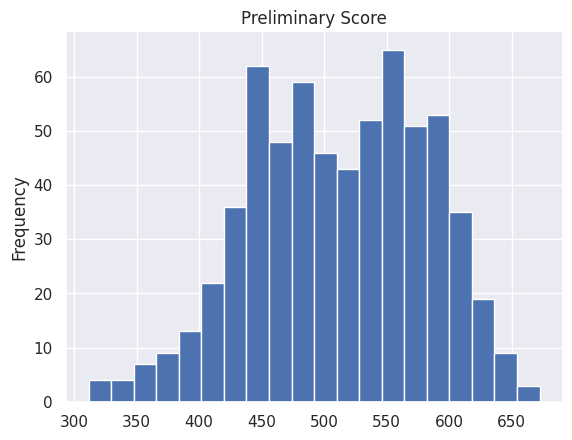

In [95]:
from matplotlib import pyplot as plt
df_preliminary_scores['Preliminary Score'].plot(kind='hist', bins=20, title='Preliminary Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [96]:
# Calculate the score for each individual based on the scorecard
# This involves multiplying the feature values by their corresponding scorecard points and summing them up
# We need to include the intercept score as well

# Extract the calculated scores from the scorecard DataFrame
score_calculations = df_scorecard.set_index('Feature name')['Score - Calculation']

# Calculate the score for each individual in the training set
# Multiply the feature values in trainX_new by the corresponding score calculations
# We need to handle the intercept separately
individual_scores = trainX_new.apply(lambda row: (row * score_calculations[trainX_new.columns]).sum() + score_calculations['Intercept'], axis=1)

# Add the individual scores to the preliminary scores DataFrame
df_preliminary_scores['Calculated Individual Score'] = individual_scores

# Display the updated preliminary scores DataFrame with the calculated individual scores
display(df_preliminary_scores.head())

,Preliminary Score,Calculated Individual Score
30,445.527885,3517.686481
263,398.197984,8385.810334
533,434.010203,7280.535075
161,465.030318,6433.795591
618,636.250726,5112.824681


### PROBABILITY OF DEFAULT

In [129]:
import numpy as np
from scipy.special import expit

y_scores = df_preliminary_scores['Preliminary Score']
min_score = y_scores.min()
max_score = y_scores.max()

# Normalize y_scores to [0,1]
y_norm = (y_scores - min_score) / (max_score - min_score)

# Define target range for sigmoid input
min_sum_coef = -10
max_sum_coef = 10

# Scale normalized y_scores to the fixed range
sum_coef_from_score = y_norm * (max_sum_coef - min_sum_coef) + min_sum_coef

# Apply stable sigmoid
y_hat_proba_from_score = expit(sum_coef_from_score)

In [130]:
y_hat_proba_from_score

,Preliminary Score
30,0.070706
263,0.005485
533,0.038622
161,0.183247
618,0.999665
...,...
726,0.006012
713,0.349107
453,0.997774
236,0.939388


### LOAN APPROVAL CUT OFFS

In [134]:
# Getting ROC Curve and their predicted probabilities.
# It returns us the false positive rates, the true positive rates, and the thresholds.
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['targets_test'],
          df_actual_predicted_probs['y_hat_test_proba'])
# Conconating 3 dataframes along the columns.
df_cutoffs = pd.concat([pd.DataFrame(thresholds), pd.DataFrame(fpr), pd.DataFrame(tpr)], axis = 1)
# Naming the columns of the dataframe 'thresholds', 'fpr', and 'tpr'.
df_cutoffs.columns = ['thresholds', 'fpr', 'tpr']
# Let the 1st threshold (the value of the thresholds column with index 0) be equal
# very close to 1 but smaller than 1
df_cutoffs['thresholds'][0] = 1 - 1 / np.power(10, 20)

# Ensure max_score, min_score, max_sum_coef, min_sum_coef are defined
# Assuming these were calculated in previous cells.
# If not, you might need to run the previous cells or define them here.

# The score corresponding to each threshold equals:
# Assuming the formula is correct based on your scorecard scaling
# Need to ensure max_score, min_score, max_sum_coef, min_sum_coef are defined
# based on your specific scorecard scaling logic
ratio_ = (max_score-min_score) / (max_sum_coef - min_sum_coef)
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * ratio_ + min_score).round()
df_cutoffs['Score'][0] = max_score
# defining a function called 'n_approved' which assigns a value of 1 if a predicted probability
def n_approved(p):
    return np.where(df_actual_predicted_probs['y_hat_test_proba'] >= p, 1, 0).sum()

# With the assumption that a given probability of being 'good' will be approved,
# we obtain # of approved applications.
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)

# Calculating # of rejected applications for each threshold.
df_cutoffs['N Rejected'] = df_actual_predicted_probs['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']

# Approval rate = the ratio of the apprv'd apps and all apps.
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / df_actual_predicted_probs['y_hat_test_proba'].shape[0]

# Rejection rate.
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']
# displaying the df with cutoffs form l/ w ind 5600 to l/ w ind 5650.
# df_cutoffs.iloc[5600: 5650, ] # Commenting this out as it might not be relevant to display only a slice here

# Display the head of the cutoffs DataFrame
display(df_cutoffs.head())

/tmp/ipython-input-2385738236.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_cutoffs['thresholds'][0] = 1 - 1 / np.power(10, 20)
/tmp/ipython-input-2385738236.py:23: FutureWarning: ChainedAssignmentError: behaviour will change in pa

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,1.000000,0.000000,0.000000,672.327003,0,160,0.00000,1.00000
1,0.942635,0.000000,0.008929,542.000000,1,159,0.00625,0.99375
2,0.917726,0.000000,0.071429,535.000000,8,152,0.05000,0.95000
3,0.917482,0.020833,0.071429,535.000000,9,151,0.05625,0.94375
4,0.885032,0.020833,0.187500,529.000000,22,138,0.13750,0.86250


What is a cutoff (or threshold)?
Imagine you have a score that shows how likely someone is to pay back a loan.
The cutoff is a number you pick to decide:
If the person’s score is above this cutoff → we say “they will pay back” (approve loan).
If the score is below this cutoff → we say “they might not pay back” (reject loan).
What is probability of default?
This is the chance that a person won’t pay back the loan.
It’s like a percentage: 0% means no chance of default, 100% means certain default.
We get this from the score after we convert it using the sigmoid function (the probabilities you calculated).
How do cutoff and probability work together?
You pick a cutoff on the score scale.
Anyone with a score below cutoff is predicted to default (not pay back).
Anyone with a score above cutoff is predicted to repay.
Example from your table:
Threshold (Cutoff)	Approval Rate	What it means
1.0	0%	Cutoff is very high → approve no one. Everyone predicted to default.
0.94	0.6%	Lower cutoff → 0.6% approved (people likely to repay)
0.91	5-6%	More people approved → you accept more loans with some risk
Why do you care about cutoff?
If cutoff is too high, you say “No” to many good borrowers → lose business.
If cutoff is too low, you say “Yes” to many risky borrowers → more defaults, lose money.
How does the probability of default help?
Instead of just yes/no, you get a probability.
You can decide how risky you want to be by picking cutoff based on probabilities.
For example, you might say: "Only approve if probability of default is less than 10%."
Summary in simple words:
Cutoff = the line that separates “likely good” from “likely bad.”
Probability of default = how risky a person is (chance they won’t pay back).
You use cutoff to decide who gets approved based on these probabilities.

# SUMMARY

# Credit Risk Modeling Summary

## Overview

We evaluated multiple machine learning models for credit risk prediction, focusing on their ability to distinguish between good and bad borrowers. The primary evaluation metric was cross-validated AUC, alongside specificity, accuracy, and recall.

## Model Comparison

| Model          | AUC (CV)      | Specificity | Accuracy | Recall     | Training Speed | Model Size           |
|----------------|---------------|-------------|----------|------------|----------------|----------------------|
| LightGBM       | Similar (best) | 57%         | 77%      | Lower      | Fastest        | ~5x smaller than RF  |
| Random Forest  | Similar       | 54%         | 74%      | Higher     | Slower         | Larger               |
| Logistic Reg.  | Similar       | Moderate    | Moderate | Highest    | Fast           | Small                |

## Key Findings

- All models achieve comparable AUC scores, indicating similar discrimination power.
- **LightGBM outperforms** other models in specificity and accuracy, with faster training and much smaller model size.
- Its only downside is lower recall compared to Logistic Regression.
- In financial contexts, **higher specificity is often more valuable** to reduce false positives (giving loans to risky borrowers).
  
## Conclusion

Given the higher specificity, better accuracy, smaller size, and faster training, we will move forward with the **LightGBM model** for credit risk prediction.

## Business Context

- The **cutoff threshold** can be adjusted to balance false positives and false negatives.
- The model outputs a **probability of default**, allowing flexible risk-based decision-making.
- Higher thresholds increase specificity but reduce recall, aligning with conservative lending strategies.

---

*This summary reflects our findings and decision rationale for model deployment in credit risk assessment.*

